In [2]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn xgboost joblib imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
# %%
import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import joblib
from imblearn.over_sampling import SMOTE
# xgboost optional
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

sns.set(style="whitegrid")
print("Setup complete. XGBoost available:", XGB_AVAILABLE)

Setup complete. XGBoost available: True


## 1. Load Datasets  

In [33]:
data = pd.read_csv("data/Loan_Default.csv")
print("Dataset shape:", data.shape)

Dataset shape: (148670, 34)


## 2. Basic Dataset Overview  

In [34]:
data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [35]:
data.tail()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0
148669,173559,2019,cf,Female,nopre,type1,p3,l1,nopc,nob/c,...,CIB,830,CIB,45-54,not_inst,72.849462,North,direct,0,44.0


In [36]:
data.shape

(148670, 34)

In [37]:
data.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

In [38]:
data.dtypes

ID                             int64
year                           int64
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int64
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score                   int64
co-applicant_credit_type      object
a

In [39]:
data.describe(include='all')

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
count,148670.000000,148670.0,145326,148670,147762,148670,148536,148670,148670,148670,...,148670,148670.000000,148670,148470,148470,133572.000000,148670,148670,148670.000000,124549.000000
unique,NaN,NaN,2,4,2,3,4,2,2,2,...,4,NaN,2,7,2,NaN,4,2,NaN,NaN
top,NaN,NaN,cf,Male,nopre,type1,p3,l1,nopc,nob/c,...,CIB,NaN,CIB,45-54,to_inst,NaN,North,direct,NaN,NaN
freq,NaN,NaN,135348,42346,124621,113173,55934,142344,148114,127908,...,48152,NaN,74392,34720,95814,NaN,74722,148637,NaN,NaN
mean,99224.500000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,699.789103,NaN,NaN,NaN,72.746457,NaN,NaN,0.246445,37.732932
std,42917.476598,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,115.875857,NaN,NaN,NaN,39.967603,NaN,NaN,0.430942,10.545435
min,24890.000000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,500.000000,NaN,NaN,NaN,0.967478,NaN,NaN,0.000000,5.000000
25%,62057.250000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,599.000000,NaN,NaN,NaN,60.474860,NaN,NaN,0.000000,31.000000
50%,99224.500000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,699.000000,NaN,NaN,NaN,75.135870,NaN,NaN,0.000000,39.000000
75%,136391.750000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,800.000000,NaN,NaN,NaN,86.184211,NaN,NaN,0.000000,45.000000


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

## 3. Handling Missing Values & Duplicates  

In [41]:
print("Missing values:\n", data.isnull().sum())
data = data.drop_duplicates().reset_index(drop=True)

for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)

print("Missing values handled.")


Missing values:
 ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
sub

## 4. Schema Definition & Data Type Conversion  

In [42]:
schema = {
    'loan_amount': 'float',
    'rate_of_interest': 'float',
    'term': 'category',
    'Credit_Score': 'float',
    'income': 'float',
    'loan_purpose': 'category',
    'Credit_Worthiness': 'category',
    'Gender': 'category',
    'Status': 'category',
    'age': 'float',
    'LTV': 'float',
    'dtir1': 'float'
}

for col, dtype in schema.items():
    if col in data.columns:
        try:
            if dtype == 'category':
                data[col] = data[col].astype('category')
            else:
                data[col] = pd.to_numeric(data[col], errors='coerce')
        except:
            pass

# Encode Status if not numeric
if not pd.api.types.is_numeric_dtype(data["Status"]):
    le = LabelEncoder()
    data["Status"] = le.fit_transform(data["Status"])
else:
    le = None

print("Schema conversion + target encoding done.")


Schema conversion + target encoding done.


## 5. Exploratory Data Visualization  

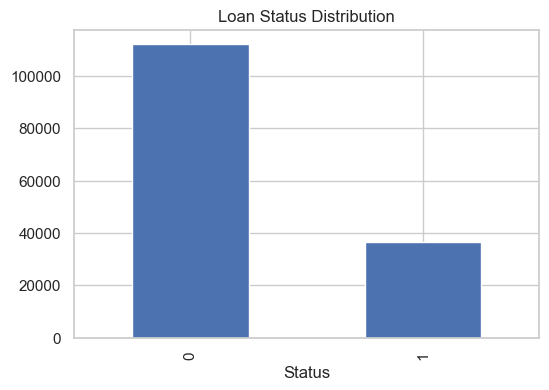

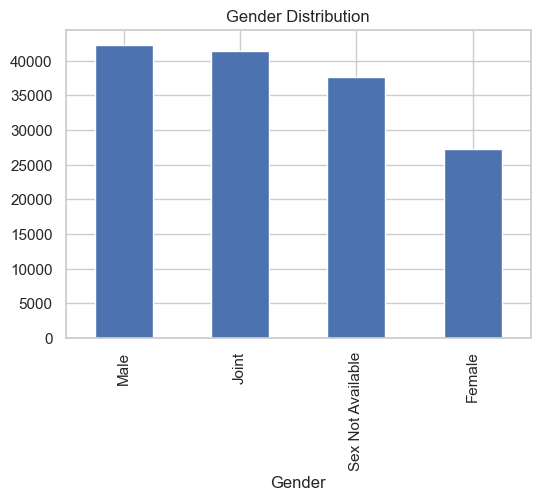

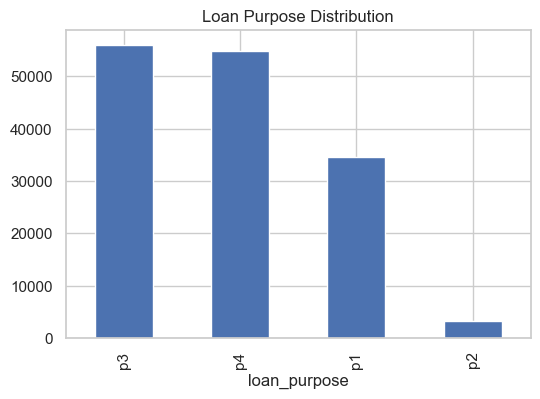

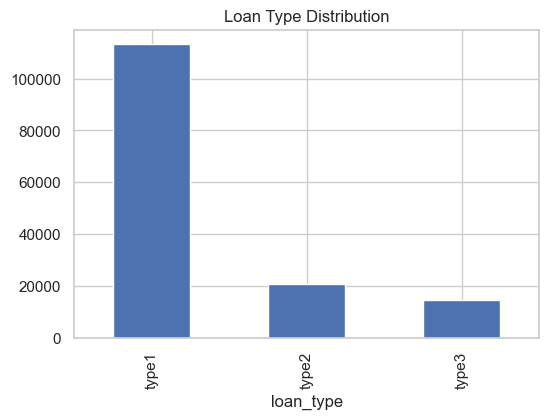

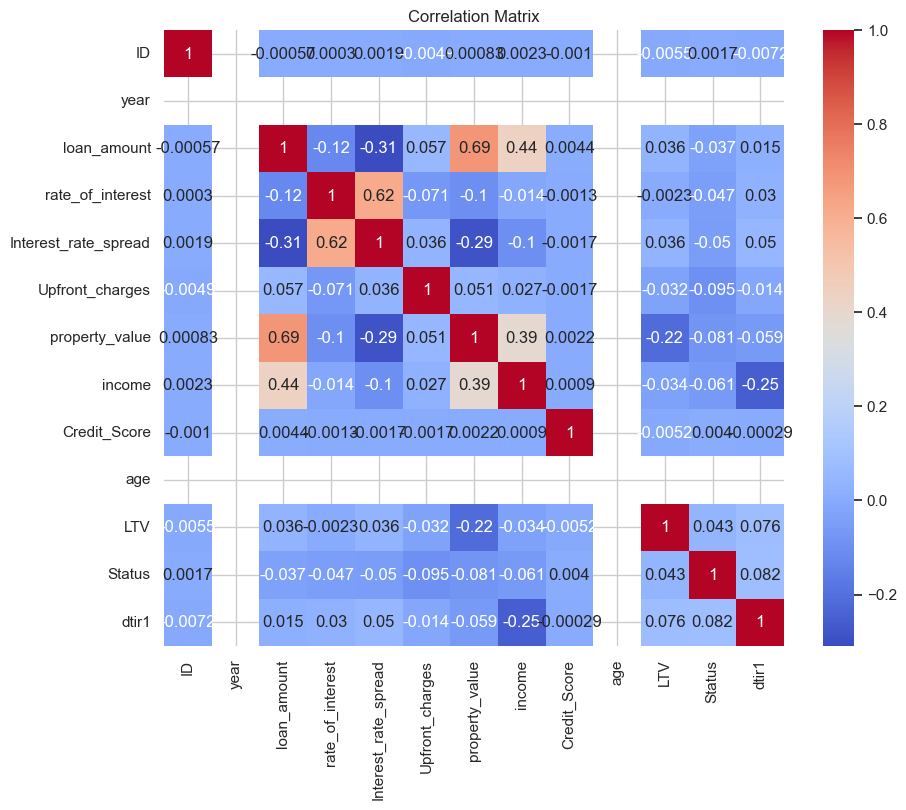

In [43]:
plt.figure(figsize=(6,4))
data['Status'].value_counts().plot(kind='bar')
plt.title("Loan Status Distribution")
plt.show()

plt.figure(figsize=(6,4))
data['Gender'].value_counts().plot(kind='bar')
plt.title("Gender Distribution")
plt.show()

plt.figure(figsize=(6,4))
data['loan_purpose'].value_counts().plot(kind='bar')
plt.title("Loan Purpose Distribution")
plt.show()

plt.figure(figsize=(6,4))
data['loan_type'].value_counts().plot(kind='bar')
plt.title("Loan Type Distribution")
plt.show()

numeric_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


**Train/Test Split + Encoding + Scaling**

In [44]:
target = "Status"
X = data.drop(columns=[target])
y = data[target]

cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = pd.DataFrame(encoder.fit_transform(X[cat_cols]), 
                     columns=encoder.get_feature_names_out(cat_cols),
                     index=X.index)

X_num = X[num_cols].reset_index(drop=True)

X_final = pd.concat([X_num, X_cat], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (118936, 90) (29734, 90)


In [49]:
# -----------------------------------------
# FIX: REMOVE ALL NAN VALUES BEFORE SMOTE
# -----------------------------------------
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print("Remaining NaNs in X_train:", X_train.isna().sum().sum())
print("Remaining NaNs in X_test:", X_test.isna().sum().sum())

Remaining NaNs in X_train: 0
Remaining NaNs in X_test: 0


**SMOTE**

In [50]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_bal).value_counts())


Class distribution after SMOTE:
Status
0    89625
1    89625
Name: count, dtype: int64


**Variance Threshold**

In [51]:
vt = VarianceThreshold(threshold=1e-4)
X_train_vt = pd.DataFrame(vt.fit_transform(X_train_bal))
X_test_vt = pd.DataFrame(vt.transform(X_test))

print("before VT:", X_train_bal.shape, X_test.shape)
X_train_fs = X_train_vt.copy()
X_test_fs = X_test_vt.copy()

print("After VT:", X_train_fs.shape, X_test_fs.shape)

before VT: (179250, 90) (29734, 90)
After VT: (179250, 83) (29734, 83)


**Feature Selection (Select K Best recommended)**

In [52]:
feature_method = "kbest"   # options: "kbest", "rfe", "from_rf", None

selector = None

if feature_method == "kbest":
    selector = SelectKBest(mutual_info_classif, k=40)
    selector.fit(X_train_fs, y_train_bal)
    Xtr_sel = selector.transform(X_train_fs)
    Xte_sel = selector.transform(X_test_fs)
elif feature_method == "rfe":
    base = LogisticRegression(max_iter=2000)
    selector = RFE(base, n_features_to_select=40)
    selector.fit(X_train_fs, y_train_bal)
    Xtr_sel = selector.transform(X_train_fs)
    Xte_sel = selector.transform(X_test_fs)
elif feature_method == "from_rf":
    rf = RandomForestClassifier(n_estimators=300)
    rf.fit(X_train_fs, y_train_bal)
    selector = SelectFromModel(rf, threshold="median", prefit=True)
    Xtr_sel = selector.transform(X_train_fs)
    Xte_sel = selector.transform(X_test_fs)
else:
    Xtr_sel = X_train_fs.values
    Xte_sel = X_test_fs.values

print("Selected features shape:", Xtr_sel.shape)


Selected features shape: (179250, 40)


In [53]:
def get_metrics(y_true, y_pred_test, y_proba_test=None):
    cm = confusion_matrix(y_true, y_pred_test)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn+fp)
    else:
        specificity = np.nan

    return (
        accuracy_score(y_true, y_pred_test),
        recall_score(y_true, y_pred_test),
        precision_score(y_true, y_pred_test),
        specificity,
        f1_score(y_true, y_pred_test),
        roc_auc_score(y_true, y_proba_test) if y_proba_test is not None else np.nan
    )

def plot_confusion(y_true, y_pred_test, title):
    cm = confusion_matrix(y_true, y_pred_test)
    cm2 = cm.T   # predicted on rows
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()


**Train Models**


Training: Logistic Regression


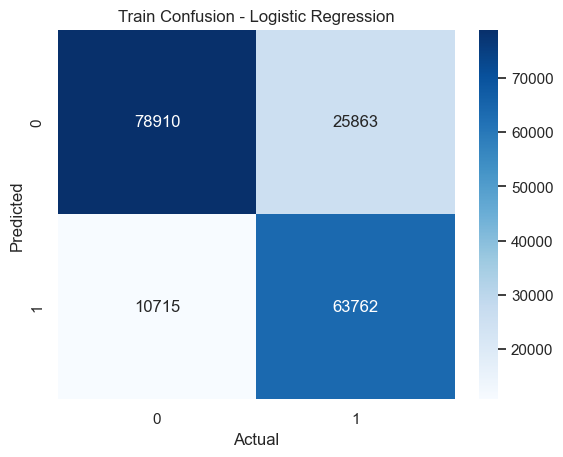

Train accuracy (Logistic Regression): 0.7959

Training: Naive Bayes


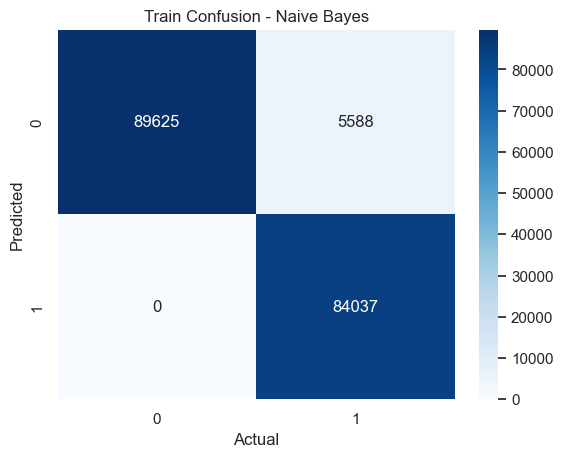

Train accuracy (Naive Bayes): 0.9688

Training: Decision Tree


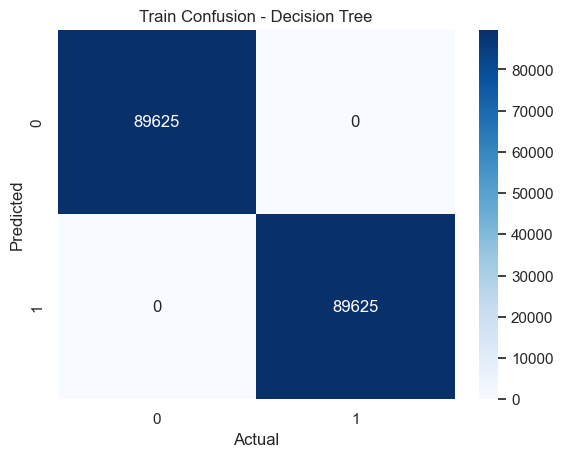

Train accuracy (Decision Tree): 1.0000

Training: Random Forest


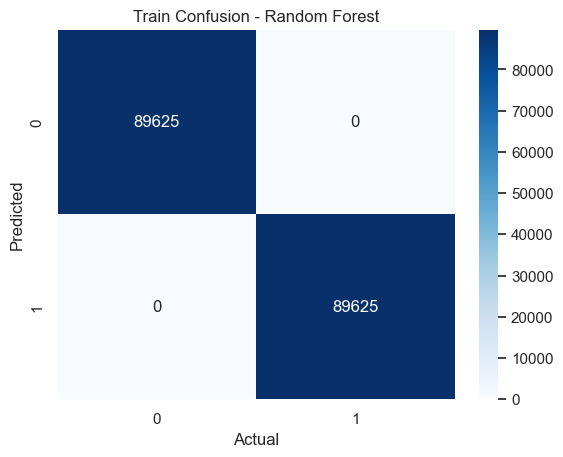

Train accuracy (Random Forest): 1.0000

Training: KNN


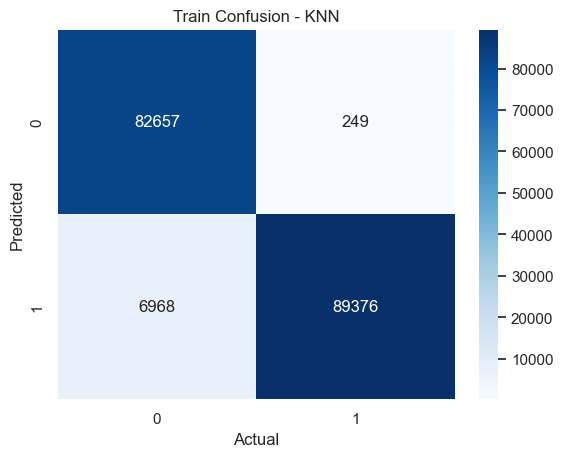

Train accuracy (KNN): 0.9597

Training: XGBoost


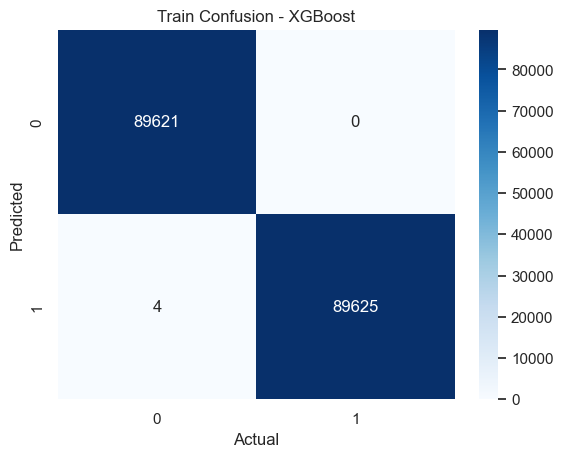

Train accuracy (XGBoost): 1.0000


In [56]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "KNN": KNeighborsClassifier(5)
}

if XGB_AVAILABLE:
    models["XGBoost"] = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss'
    )

trained_models = {}
train_results = []

for name, model in models.items():
    print("\nTraining:", name)
    model.fit(Xtr_sel, y_train_bal)
    trained_models[name] = model

    # TRAIN metrics (use Xtr_sel and y_train_bal)
    y_pred_train = model.predict(Xtr_sel)
    y_proba_train = model.predict_proba(Xtr_sel)[:,1] if hasattr(model, 'predict_proba') else None

    acc_tr, sens_tr, prec_tr, spec_tr, f1_tr, auc_tr = get_metrics(y_train_bal, y_pred_train, y_proba_train)
    train_results.append([name, acc_tr, sens_tr, prec_tr, spec_tr, f1_tr, auc_tr])

    # Plot train confusion (predicted on rows as you implemented)
    plot_confusion(y_train_bal, y_pred_train, f"Train Confusion - {name}")

    print(f"Train accuracy ({name}): {acc_tr:.4f}")

**Train MLP (ReLU / Tanh / Sigmoid)**


Training: MLP_relu


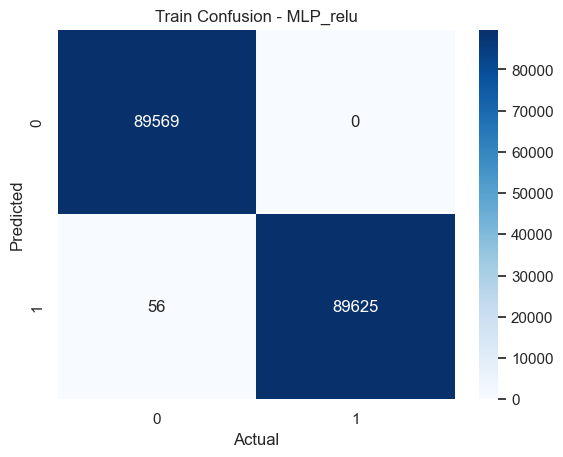

0.9996875871687587

Training: MLP_tanh


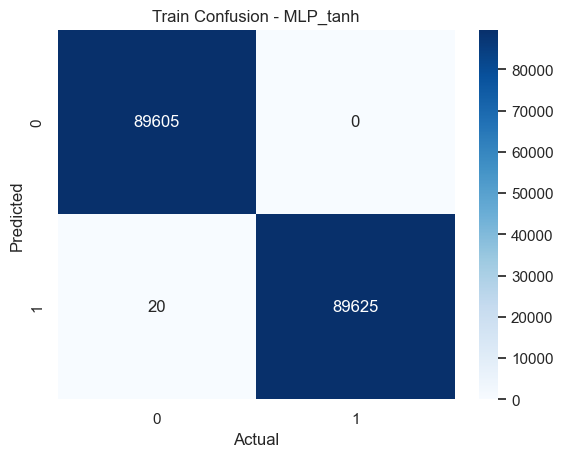

0.9998884239888424

Training: MLP_logistic


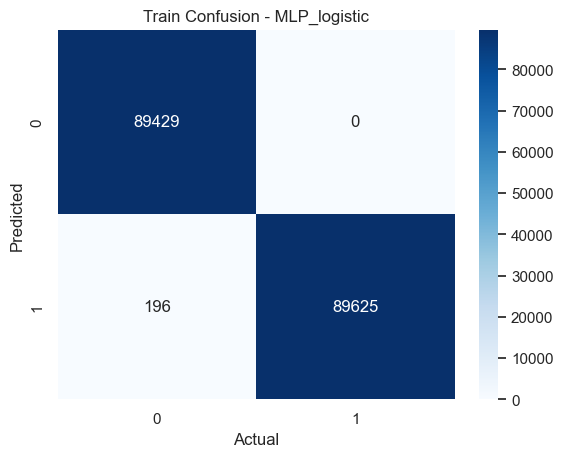

0.9989065550906555


In [ ]:
for act in ['relu','tanh','logistic']:
    name = f"MLP_{act}"
    print("\nTraining:", name)

    mlp = MLPClassifier(hidden_layer_sizes=(128,64), activation=act, max_iter=500)
    mlp.fit(Xtr_sel, y_train_bal)

    trained_models[name] = mlp

    y_pred_train = mlp.predict(Xtr_sel)
    y_proba_train = mlp.predict_proba(Xtr_sel)[:,1]

    acc, sens, prec, spec, f1, auc = get_metrics(y_train_bal, y_pred_train, y_proba_train)
    train_results.append([name, acc, sens, prec, spec, f1, auc])

    plot_confusion(y_train_bal, y_pred_train, f"Train Confusion - {name}")
    print(accuracy_score(y_train_bal, y_pred_train))

In [58]:
train_df = pd.DataFrame(train_results,
                        columns=["Model","Accuracy","Sensitivity","Precision","Specificity","F1","AUC"])
display(train_df)
train_df.to_csv("train_results.csv", index=False)
print("Saved train_results.csv") 

,Model,Accuracy,Sensitivity,Precision,Specificity,F1,AUC
0,Logistic Regression,0.795939,0.711431,0.856130,0.880446,0.777102,0.868924
1,Naive Bayes,0.968826,0.937651,1.000000,1.000000,0.967823,0.999989
2,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,KNN,0.959738,0.997222,0.927676,0.922254,0.961192,0.998351
5,XGBoost,0.999978,1.000000,0.999955,0.999955,0.999978,1.000000
6,MLP_relu,0.999688,1.000000,0.999376,0.999375,0.999688,0.999988
7,MLP_tanh,0.999888,1.000000,0.999777,0.999777,0.999888,1.000000
8,MLP_logistic,0.998907,1.000000,0.997818,0.997813,0.998908,0.999950


Saved train_results.csv


In [59]:
# ---------------------------------------------------------
# 8️⃣ MATHEMATICAL EQUATION–BASED MODEL BEHAVIOR
# ---------------------------------------------------------
import numpy as np

print("\n📘 APPLYING MATHEMATICAL EQUATIONS ON TRAINED MODELS\n")

# -------------------------
# LOGISTIC REGRESSION
# -------------------------
if "Logistic Regression" in trained_models:
    lr = trained_models["Logistic Regression"]
    print("\n🔹 Logistic Regression Mathematical Prediction")
    
    W = lr.coef_.flatten()
    b = lr.intercept_[0]
    
    def logistic_manual_predict(X):
        z = np.dot(X, W) + b
        return 1 / (1 + np.exp(-z))
    
    logistic_manual_outputs = logistic_manual_predict(Xte_sel)
    print("Sample manual predictions:", logistic_manual_outputs[:5])

# -------------------------
# SVM (Linear Only)
# -------------------------
if "SVM" in trained_models or "Linear SVM" in trained_models or "Linear SVM " in trained_models:
    svm_key = [k for k in trained_models if "SVM" in k][0]
    svm = trained_models[svm_key]
    print("\n🔹 SVM Mathematical Decision Function")

    W = svm.coef_.flatten() if hasattr(svm, "coef_") else None
    b = svm.intercept_[0] if hasattr(svm, "intercept_") else None

    if W is not None:
        def svm_decision_fn(X):
            return np.dot(X, W) + b
        
        svm_manual_outputs = svm_decision_fn(Xte_sel)
        print("Sample decision function outputs:", svm_manual_outputs[:5])
    else:
        print("SVM kernel is not linear → cannot compute mathematical formula")

# -------------------------
# DECISION TREE
# -------------------------
if "Decision Tree" in trained_models:
    from sklearn.tree import export_text
    dt = trained_models["Decision Tree"]
    
    print("\n🔹 Decision Tree Mathematical Rules")
    rules = export_text(dt, feature_names=[f"F{i}" for i in range(Xtr_sel.shape[1])])
    print(rules)

# -------------------------
# RANDOM FOREST
# -------------------------
if "Random Forest" in trained_models:
    rf = trained_models["Random Forest"]

    print("\n🔹 Random Forest Mathematical Behavior")
    print("Each tree votes → final prediction is majority vote.")

    # show average probability from 3 sample rows
    rf_probs = rf.predict_proba(Xte_sel)
    print("Sample RF probabilities:", rf_probs[:3])

# -------------------------
# XGBOOST
# -------------------------
if "XGBoost" in trained_models:
    xgb = trained_models["XGBoost"]

    print("\n🔹 XGBoost Mathematical Output")
    xgb_raw = xgb.predict_proba(Xte_sel)
    print("Sample XGB raw outputs:", xgb_raw[:3])

# -------------------------
# MLP Neural Network
# -------------------------
for key in trained_models:
    if "MLP" in key:
        mlp = trained_models[key]
        print(f"\n🔹 {key} Mathematical Forward Propagation Output")

        mlp_raw = mlp.predict_proba(Xte_sel)[:3]
        print("Sample outputs:", mlp_raw)



📘 APPLYING MATHEMATICAL EQUATIONS ON TRAINED MODELS


🔹 Logistic Regression Mathematical Prediction
Sample manual predictions: [0.21220613 0.35454862 0.22137193 0.23747389 0.53620472]

🔹 Decision Tree Mathematical Rules
|--- F2 <= -0.09
|   |--- class: 0
|--- F2 >  -0.09
|   |--- F2 <= -0.09
|   |   |--- F1 <= -1.47
|   |   |   |--- class: 0
|   |   |--- F1 >  -1.47
|   |   |   |--- F3 <= 2.27
|   |   |   |   |--- F3 <= 1.59
|   |   |   |   |   |--- F3 <= -0.15
|   |   |   |   |   |   |--- F3 <= -0.85
|   |   |   |   |   |   |   |--- F32 <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- F32 >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- F3 >  -0.85
|   |   |   |   |   |   |   |--- F1 <= -0.57
|   |   |   |   |   |   |   |   |--- F38 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- F38 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   | 


Testing: Logistic Regression


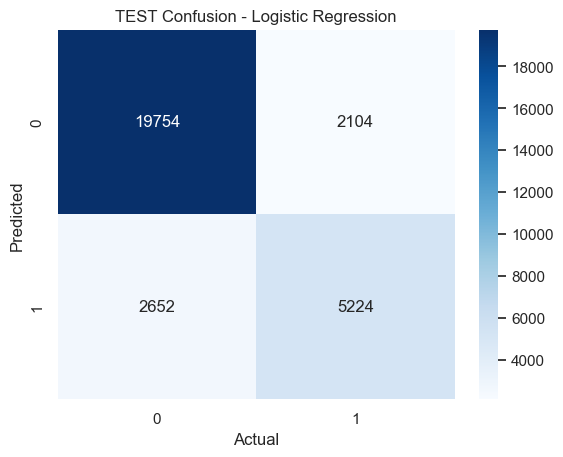

Test accuracy (Logistic Regression): 0.8400

Testing: Naive Bayes


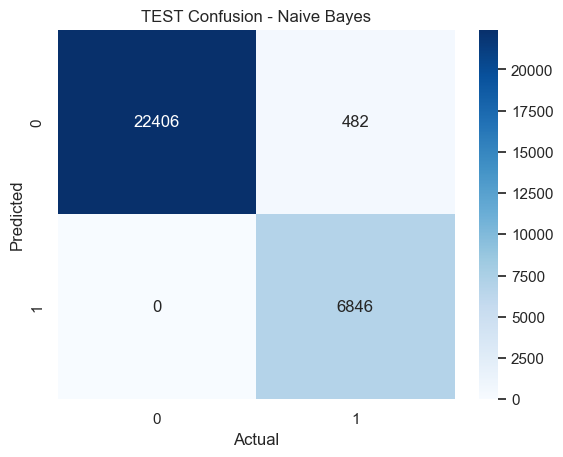

Test accuracy (Naive Bayes): 0.9838

Testing: Decision Tree


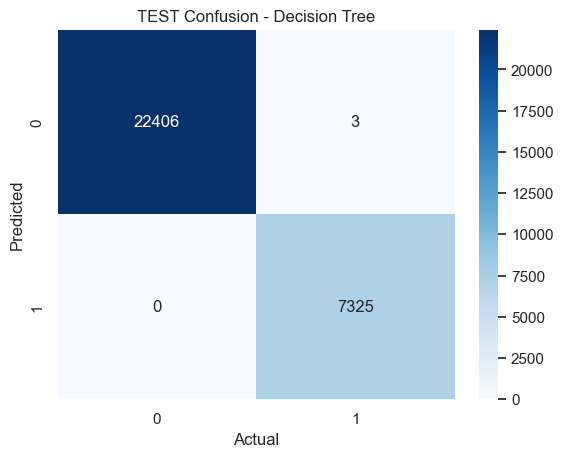

Test accuracy (Decision Tree): 0.9999

Testing: Random Forest


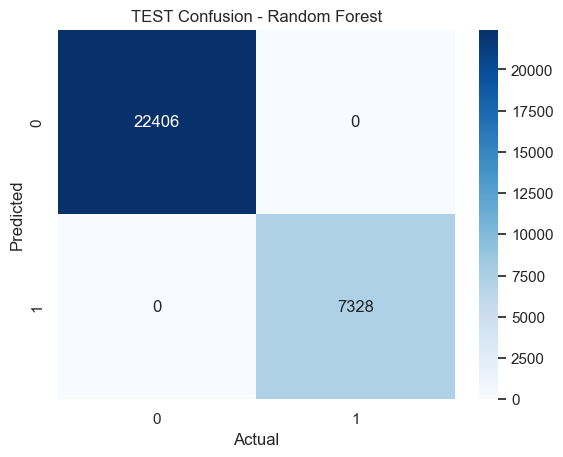

Test accuracy (Random Forest): 1.0000

Testing: KNN


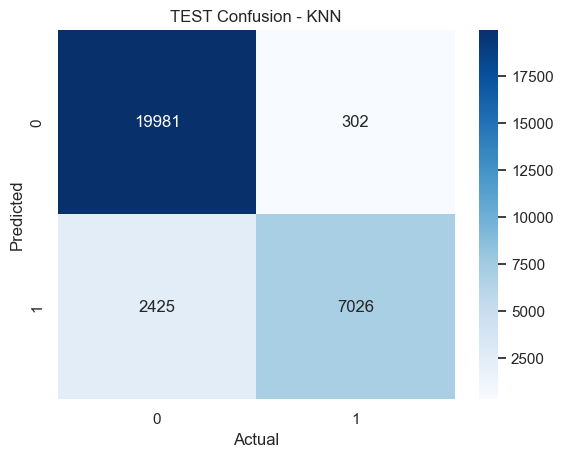

Test accuracy (KNN): 0.9083

Testing: XGBoost


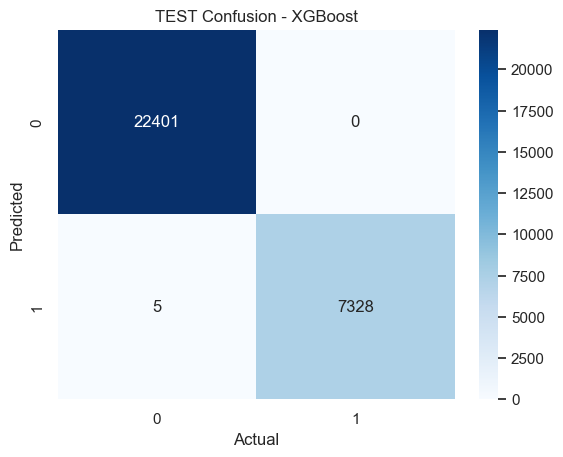

Test accuracy (XGBoost): 0.9998

Testing: MLP_relu


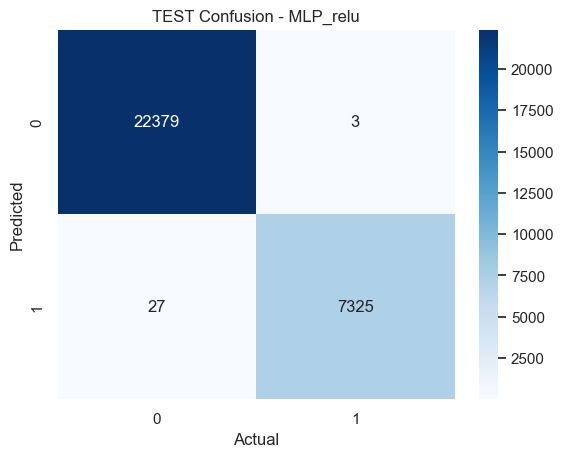

Test accuracy (MLP_relu): 0.9990

Testing: MLP_tanh


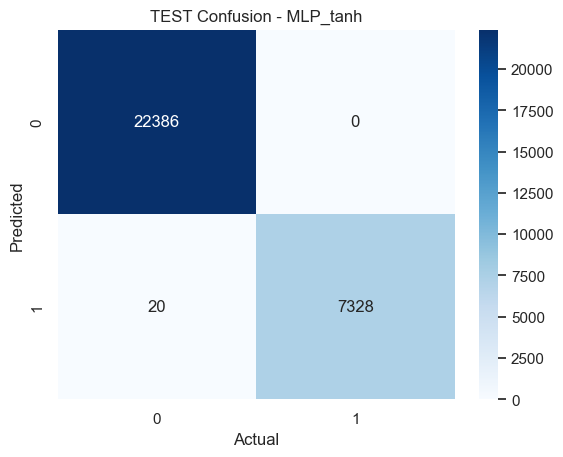

Test accuracy (MLP_tanh): 0.9993

Testing: MLP_logistic


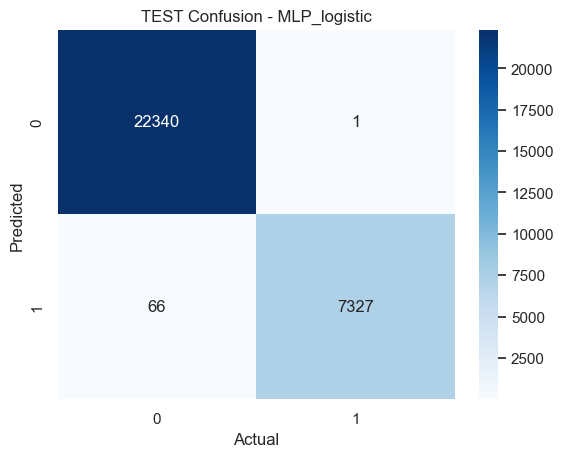

Test accuracy (MLP_logistic): 0.9977


In [60]:
test_results = []

for name, model in trained_models.items():
    print("\nTesting:", name)

    # TEST metrics (use Xte_sel and y_test)
    y_pred_test = model.predict(Xte_sel)
    y_proba_test = model.predict_proba(Xte_sel)[:,1] if hasattr(model, 'predict_proba') else None

    acc_te, sens_te, prec_te, spec_te, f1_te, auc_te = get_metrics(y_test, y_pred_test, y_proba_test)
    test_results.append([name, acc_te, sens_te, prec_te, spec_te, f1_te, auc_te])

    plot_confusion(y_test, y_pred_test, f"TEST Confusion - {name}")
    print(f"Test accuracy ({name}): {acc_te:.4f}")


In [61]:
test_df = pd.DataFrame(test_results,
                       columns=["Model","Accuracy","Sensitivity","Precision","Specificity","F1","AUC"])
display(test_df)
test_df.to_csv("test_results.csv", index=False)
print("Saved test_results.csv")

,Model,Accuracy,Sensitivity,Precision,Specificity,F1,AUC
0,Logistic Regression,0.840048,0.712882,0.663281,0.881639,0.687188,0.866079
1,Naive Bayes,0.983790,0.934225,1.000000,1.000000,0.965994,1.000000
2,Decision Tree,0.999899,0.999591,1.000000,1.000000,0.999795,0.999795
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,KNN,0.908287,0.958788,0.743413,0.891770,0.837475,0.970579
5,XGBoost,0.999832,1.000000,0.999318,0.999777,0.999659,0.999972
6,MLP_relu,0.998991,0.999591,0.996328,0.998795,0.997956,0.999853
7,MLP_tanh,0.999327,1.000000,0.997278,0.999107,0.998637,0.999972
8,MLP_logistic,0.997747,0.999864,0.991073,0.997054,0.995449,0.999879


Saved test_results.csv


**Hyperparameter Tuning****

In [63]:
from sklearn.model_selection import GridSearchCV

tuned_models = {}

print("Starting Hyperparameter Tuning...")

# --------------------------
# Logistic Regression
# --------------------------
param_lr = {
    'C': [0.01, 0.1, 1, 10, 50],
    'solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=5000),
                       param_grid=param_lr,
                       scoring='accuracy',
                       cv=3,
                       n_jobs=-1)

grid_lr.fit(Xtr_sel, y_train_bal)
tuned_models["LogReg_Tuned"] = grid_lr.best_estimator_
print("Logistic Regression Best Params:", grid_lr.best_params_)

# --------------------------
# Random Forest
# --------------------------
param_rf = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 7, 10, None],
    'min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(RandomForestClassifier(),
                       param_grid=param_rf,
                       scoring='accuracy',
                       cv=3,
                       n_jobs=-1)

grid_rf.fit(Xtr_sel, y_train_bal)
tuned_models["RF_Tuned"] = grid_rf.best_estimator_
print("Random Forest Best Params:", grid_rf.best_params_)

# --------------------------
# XGBoost
# --------------------------
if XGB_AVAILABLE:
    param_xgb = {
        'n_estimators': [200, 300],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }

    grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss'),
                            param_grid=param_xgb,
                            scoring='accuracy',
                            cv=3,
                            n_jobs=-1)
    grid_xgb.fit(Xtr_sel, y_train_bal)
    tuned_models["XGB_Tuned"] = grid_xgb.best_estimator_
    print("XGBoost Best Params:", grid_xgb.best_params_)


# --------------------------
# MLP Neural Network
# --------------------------
param_mlp = {
    'hidden_layer_sizes': [(128,), (128,64), (256,128)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01]
}

grid_mlp = GridSearchCV(
    MLPClassifier(max_iter=500),
    param_grid=param_mlp,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
grid_mlp.fit(Xtr_sel, y_train_bal)
tuned_models["MLP_Tuned"] = grid_mlp.best_estimator_
print("MLP Best Params:", grid_mlp.best_params_)

print("\nHyperparameter Tuning Complete.")


Starting Hyperparameter Tuning...
Logistic Regression Best Params: {'C': 50, 'solver': 'liblinear'}
Random Forest Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
XGBoost Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 1.0}
MLP Best Params: {'activation': 'relu', 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}

Hyperparameter Tuning Complete.


**Evaluate Tuned Models**


Evaluating: LogReg_Tuned


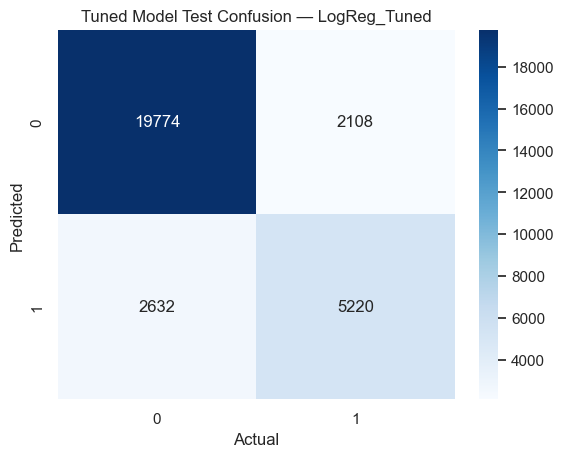


Evaluating: RF_Tuned


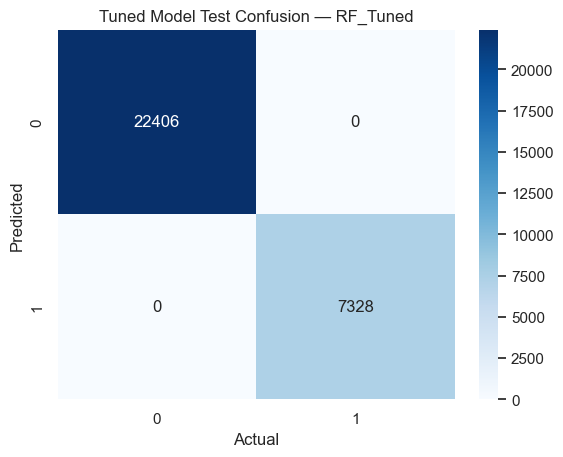


Evaluating: XGB_Tuned


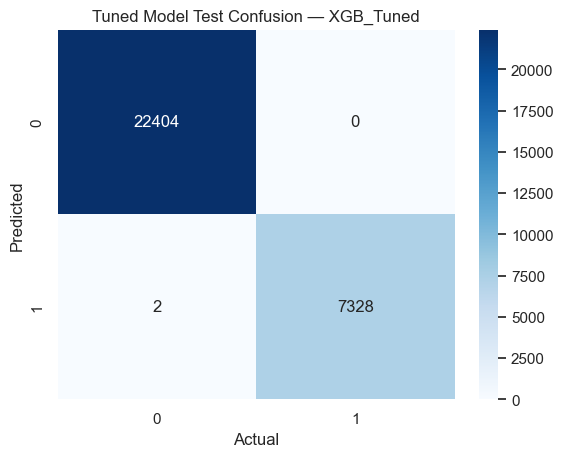


Evaluating: MLP_Tuned


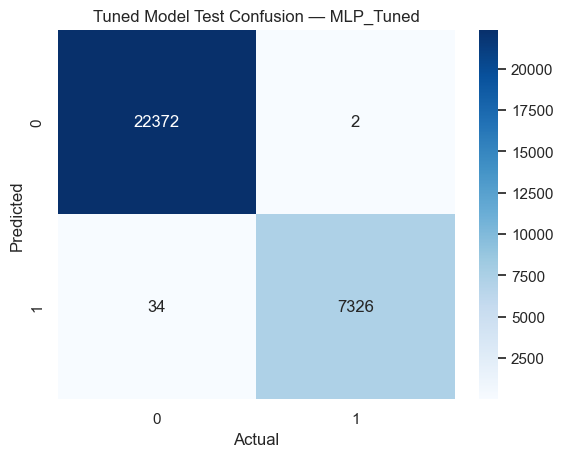

,Model,Acc,Sens,Prec,Spec,F1,AUC
0,LogReg_Tuned,0.796123,0.711431,0.856510,0.880815,0.777258,0.869310
1,RF_Tuned,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,XGB_Tuned,0.999950,1.000000,0.999900,0.999900,0.999950,1.000000
3,MLP_Tuned,0.999370,1.000000,0.998741,0.998739,0.999370,0.999954


,Model,Acc,Sens,Prec,Spec,F1,AUC
0,LogReg_Tuned,0.840587,0.712336,0.664799,0.882531,0.687747,0.866116
1,RF_Tuned,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,XGB_Tuned,0.999933,1.000000,0.999727,0.999911,0.999864,0.999968
3,MLP_Tuned,0.998789,0.999727,0.995380,0.998483,0.997549,0.999873


0.9987892648146902
Saved tuned model results.


In [67]:
tuned_results_train = []
tuned_results_test = []

for name, model in tuned_models.items():
    print("\nEvaluating:", name)

    # Train metrics
    ytr = model.predict(Xtr_sel)
    ytr_p = model.predict_proba(Xtr_sel)[:,1] if hasattr(model,'predict_proba') else None
    tr_acc,tr_sen,tr_pre,tr_spec,tr_f1,tr_auc = get_metrics(y_train_bal, ytr, ytr_p)

    tuned_results_train.append([name, tr_acc,tr_sen,tr_pre,tr_spec,tr_f1,tr_auc])

    # Test metrics
    yte = model.predict(Xte_sel)
    yte_p = model.predict_proba(Xte_sel)[:,1] if hasattr(model,'predict_proba') else None
    te_acc,te_sen,te_pre,te_spec,te_f1,te_auc = get_metrics(y_test, yte, yte_p)

    tuned_results_test.append([name, te_acc,te_sen,te_pre,te_spec,te_f1,te_auc])

    plot_confusion(y_test, yte, f"Tuned Model Test Confusion — {name}")

tuned_train_df = pd.DataFrame(tuned_results_train,
                  columns=["Model","Acc","Sens","Prec","Spec","F1","AUC"])

tuned_test_df = pd.DataFrame(tuned_results_test,
                  columns=["Model","Acc","Sens","Prec","Spec","F1","AUC"])

display(tuned_train_df)
display(tuned_test_df)
print(accuracy_score(y_test, yte))
tuned_train_df.to_csv("tuned_model_train_results.csv", index=False)
tuned_test_df.to_csv("tuned_model_test_results.csv", index=False)
print("Saved tuned model results.")

**Top 10 Features**

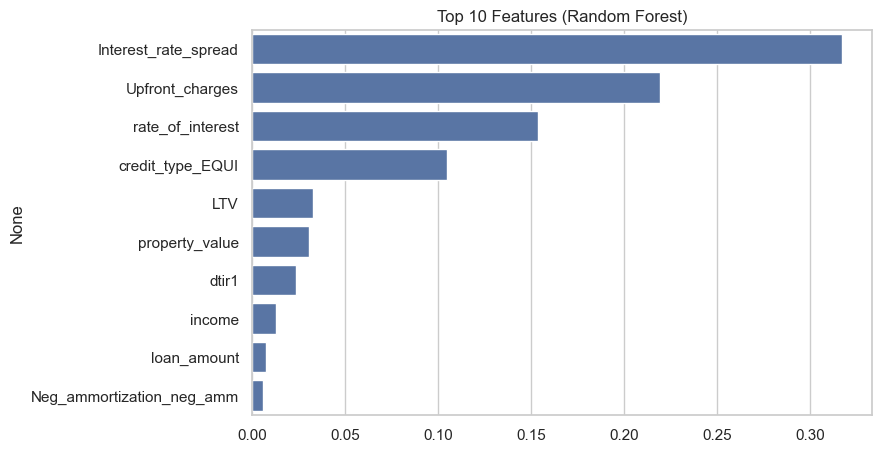

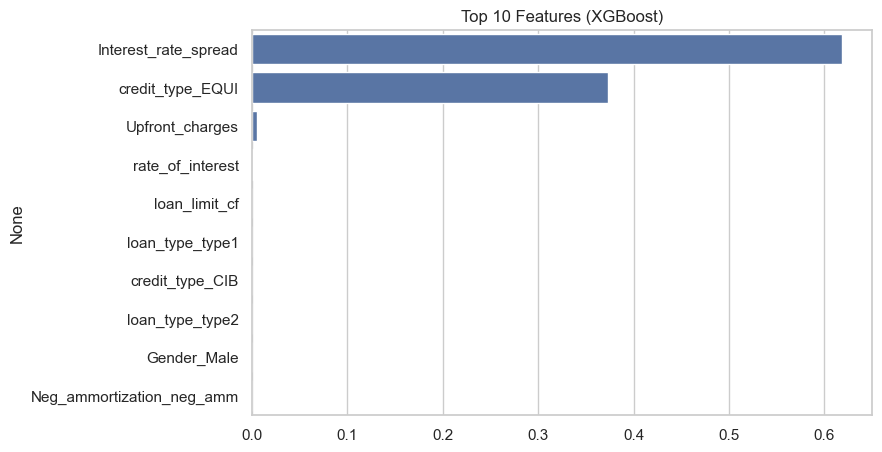

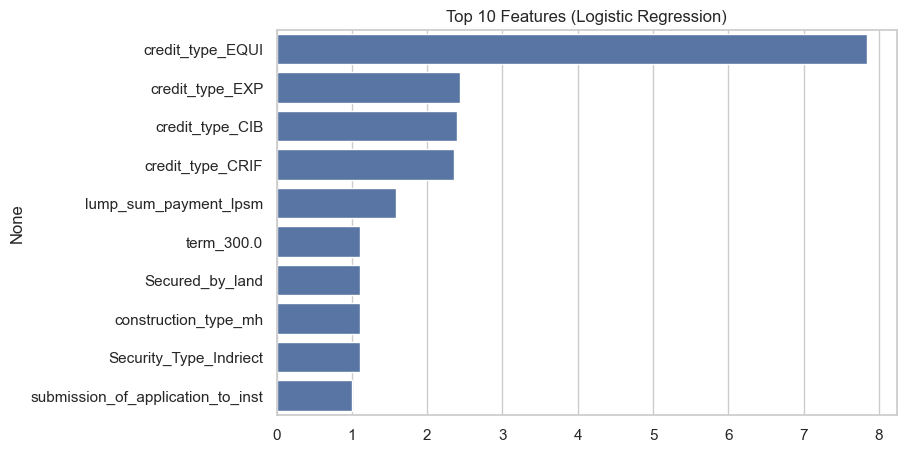

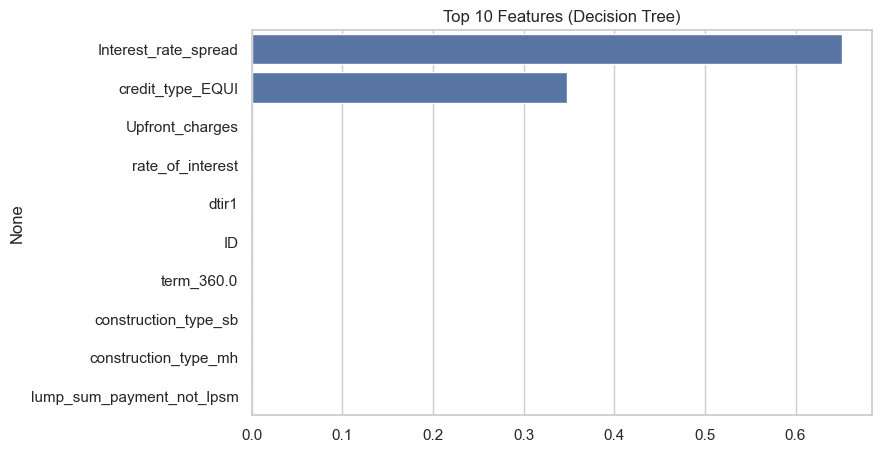

In [71]:
# Random Forest importance
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

imp = pd.Series(rf.feature_importances_, index=X_train.columns)
top10_rf = imp.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top10_rf.values, y=top10_rf.index)
plt.title("Top 10 Features (Random Forest)")
plt.show()

# XGBoost Importance
if XGB_AVAILABLE:
    xgb = XGBClassifier(eval_metric='logloss')
    xgb.fit(X_train, y_train)
    imp_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns)
    top10_xgb = imp_xgb.sort_values(ascending=False).head(10)

    plt.figure(figsize=(8,5))
    sns.barplot(x=top10_xgb.values, y=top10_xgb.index)
    plt.title("Top 10 Features (XGBoost)")
    plt.show()

# Logistic Regression coefficients
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train, y_train)

coefs = pd.Series(abs(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=coefs.values, y=coefs.index)
plt.title("Top 10 Features (Logistic Regression)")
plt.show()

#decision tree feature importance
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_imp = pd.Series(dt.feature_importances_, index=X_train.columns)
top10_dt = dt_imp.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top10_dt.values, y=top10_dt.index)
plt.title("Top 10 Features (Decision Tree)")
plt.show()

**Compare ALL Models**

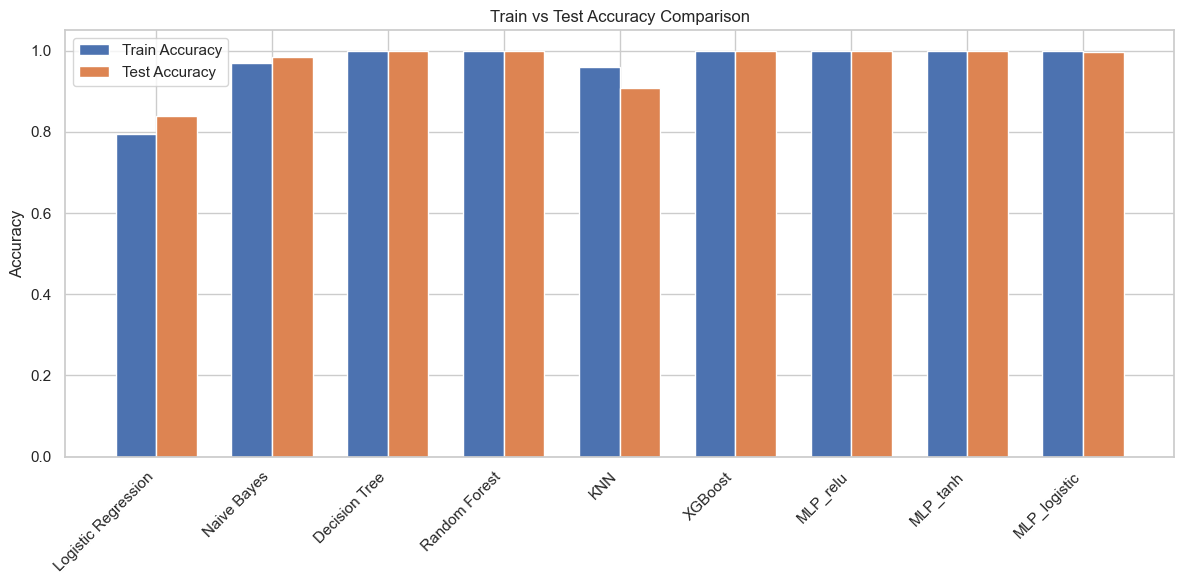

Saved model: saved_models/Logistic_Regression.joblib
Saved model: saved_models/Naive_Bayes.joblib
Saved model: saved_models/Decision_Tree.joblib
Saved model: saved_models/Random_Forest.joblib
Saved model: saved_models/KNN.joblib
Saved model: saved_models/XGBoost.joblib
Saved model: saved_models/MLP_relu.joblib
Saved model: saved_models/MLP_tanh.joblib
Saved model: saved_models/MLP_logistic.joblib


In [72]:
combined = test_df.merge(train_df, on="Model", suffixes=("_Test","_Train"))

plt.figure(figsize=(12,6))

x = np.arange(len(combined))
width = 0.35

plt.bar(x - width/2, combined["Accuracy_Train"], width, label="Train Accuracy")
plt.bar(x + width/2, combined["Accuracy_Test"], width, label="Test Accuracy")

plt.xticks(x, combined["Model"], rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Comparison")
plt.legend()
plt.tight_layout()
plt.show()
# Save models
os.makedirs("saved_models", exist_ok=True)
for model_name, model in trained_models.items():
    filename = f"saved_models/{model_name.replace(' ','_')}.joblib"
    joblib.dump(model, filename)
    print(f"Saved model: {filename}")
    

**Best Model**

In [73]:
best_model_name = test_df.sort_values("Accuracy", ascending=False).iloc[0]["Model"]
best_model = trained_models[best_model_name]

print("\nBest Model:", best_model_name)

payload = {
    "encoder": encoder,
    "scaler": scaler,
    "selector": selector,
    "model": best_model,
    "feature_names": list(X_final.columns),
    "label_encoder": le
}

joblib.dump(payload, "PurviModel.joblib")
print("PurviModel.joblib saved successfully!")



Best Model: Random Forest
PurviModel.joblib saved successfully!
